In [32]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import math
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight
import kagglehub

Arrythmia Dataset
- Number of samples: 109446
- Number of categories: 5
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrythmia Dataset

In [33]:
# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [35]:
# Set seeds
seed_value = 0
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Data exploration

In [36]:
train_df = pd.read_csv(path + '/mitbih_train.csv')
test_df = pd.read_csv(path + '/mitbih_test.csv')

In [37]:
print(f"Shape of train data: {train_df.shape}")
print(f"Shape of test data: {test_df.shape}")

Shape of train data: (87553, 188)
Shape of test data: (21891, 188)


In [38]:
# If your dataframes don't have column names, assign them
# This creates columns named '0', '1', '2', ...
train_df.columns = [i for i in range(train_df.shape[1])]
test_df.columns = [i for i in range(test_df.shape[1])]

In [39]:
print(f"NaN values in train data: {train_df.isna().sum().sum()}")
print(f"NaN values in test data: {test_df.isna().sum().sum()}")

NaN values in train data: 0
NaN values in test data: 0


In [40]:
# Last column stores the labels
print(train_df.iloc[:, -1].unique())
print(test_df.iloc[:, -1].unique())

[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]


In [41]:
train_df.iloc[:, -1].value_counts()

187
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

In [42]:
test_df.iloc[:, -1].value_counts()

187
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

From the counts of the classes, we can observe that the dataset is imbalanced, as class = 0 makes up a large proportion of the training (82.77%) and test data (82.76%). However, we will go ahead with training and evaluating for now and observe the results.

## Generating Training Data

In [43]:
class_datasets = {}
labels = train_df[187].unique()  # Get the unique labels

# Dictionary to hold DataLoaders for each class
class_train_dataloaders = {}
class_val_dataloaders = {}

# Splitting each class-specific dataset into training and validation sets
for label in labels:
    # Filter the DataFrame for each class
    class_data = train_df[train_df[187] == label].drop(columns=[187]).values  # Drop label column for data
    class_labels = train_df[train_df[187] == label][187].values  # Labels for the class

    # Split data into training and validation sets
    train_data, val_data, train_labels, val_labels = train_test_split(
        class_data, class_labels, test_size=0.2, random_state=42
    )

    # Convert to tensors
    train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
    val_data_tensor = torch.tensor(val_data, dtype=torch.float32)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
    
    # Create TensorDatasets
    train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
    val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
    
    # Create DataLoaders for training and validation
    class_train_dataloaders[label] = DataLoader(train_dataset, batch_size=32, shuffle=True)
    class_val_dataloaders[label] = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [44]:
x_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

## Autoencoder Model

In [45]:
# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [46]:
def train_autoencoder_loop(train_dataloader, autoencoder, loss_fn, optimizer):
    autoencoder.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss = 0

    for batch, (X, _) in enumerate(train_dataloader):  # No labels needed for reconstruction
        # Move inputs to the same device as the model (GPU or CPU)
        X = X.to(device)

        # Forward pass: Encode and decode
        _, reconstructed = autoencoder(X)
        loss = loss_fn(reconstructed, X)  # Compute reconstruction loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    return train_loss

def test_autoencoder_loop(test_dataloader, autoencoder, loss_fn):
    autoencoder.eval()
    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, _ in test_dataloader:
            X = X.to(device)

            # Forward pass: Encode and decode
            _, reconstructed = autoencoder(X)
            test_loss += loss_fn(reconstructed, X).item()  # Compute reconstruction loss

    test_loss /= num_batches
    return test_loss

In [47]:
class EarlyStopper:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

## Training & Evaluation of Model

In [71]:
input_dim = 187
encoding_dim = 64
num_classes = 5

patience = 3
no_epochs = 100
batch_size = 64
lr = 0.001

In [72]:
# Define the autoencoder training function
def train_autoencoder(autoencoder, optimizer, train_loader, test_loader, num_epochs=20):
    loss_fn = nn.MSELoss()
    early_stopper = EarlyStopper(patience=patience, min_delta=0)

    for epoch in range(num_epochs):
        # Train on the training dataset
        train_loss = train_autoencoder_loop(train_loader, autoencoder, loss_fn, optimizer)

        # Evaluate on the test dataset
        test_loss = test_autoencoder_loop(test_loader, autoencoder, loss_fn)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:>8f}, Val Loss: {test_loss:>8f}")

        if early_stopper.early_stop(test_loss):
          print('Done')
          break

In [73]:
def classify_sample(sample, class_autoencoders):
    sample = sample.to(device)
    errors = []

    for class_label, model in class_autoencoders.items():
        model.eval()
        with torch.no_grad():
            _, reconstructed = model(sample)
            # Calculate the reconstruction error (MSE)
            error = torch.mean((sample - reconstructed) ** 2).item()
            errors.append((class_label, error))
    
    # Select the class with the lowest reconstruction error
    predicted_class = min(errors, key=lambda x: x[1])[0]
    return predicted_class

In [74]:
# Create a dictionary to hold autoencoders for each class
class_autoencoders = {}
optimizers = {}

# Instantiate and train each class-specific autoencoder
for class_label in range(num_classes):
    model = Autoencoder(input_dim, encoding_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    class_autoencoders[class_label] = model
    optimizers[class_label] = optimizer

In [81]:
print(class_autoencoders[0])

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=187, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=187, bias=True)
  )
)


In [75]:
# Train the autoencoder
print("Training Autoencoders")
for cls in range(num_classes):
    print(f"Training Autoencoder for class {cls}")
    train_autoencoder(class_autoencoders[cls], optimizers[cls], class_train_dataloaders[cls], class_val_dataloaders[cls], num_epochs=no_epochs)

Training Autoencoders
Training Autoencoder for class 0
Epoch [1/100], Train Loss: 0.006130, Val Loss: 0.002457
Epoch [2/100], Train Loss: 0.001930, Val Loss: 0.001692
Epoch [3/100], Train Loss: 0.001366, Val Loss: 0.001307
Epoch [4/100], Train Loss: 0.001116, Val Loss: 0.001071
Epoch [5/100], Train Loss: 0.000958, Val Loss: 0.000950
Epoch [6/100], Train Loss: 0.000862, Val Loss: 0.000824
Epoch [7/100], Train Loss: 0.000774, Val Loss: 0.000889
Epoch [8/100], Train Loss: 0.000722, Val Loss: 0.000716
Epoch [9/100], Train Loss: 0.000668, Val Loss: 0.000673
Epoch [10/100], Train Loss: 0.000618, Val Loss: 0.000623
Epoch [11/100], Train Loss: 0.000591, Val Loss: 0.000560
Epoch [12/100], Train Loss: 0.000562, Val Loss: 0.000593
Epoch [13/100], Train Loss: 0.000532, Val Loss: 0.000560
Epoch [14/100], Train Loss: 0.000516, Val Loss: 0.000511
Epoch [15/100], Train Loss: 0.000500, Val Loss: 0.000492
Epoch [16/100], Train Loss: 0.000477, Val Loss: 0.000552
Epoch [17/100], Train Loss: 0.000463, Val 

In [76]:
# Convert data to TensorDataset for DataLoader
test_dataset = TensorDataset(x_test, y_test)

# Loaders for batching
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [82]:
all_preds = []
all_labels = []
correct = 0
total = 0

for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    
    # Loop through each sample in the batch
    for i in range(X.size(0)):  # X.size(0) gives the batch size
        sample = X[i].unsqueeze(0)  # Unsqueeze to get the correct shape for a single sample
        true_label = y[i].item()  # Get the label for the current sample

        # Get the predicted class using the classify_sample function
        predicted_class = classify_sample(sample, class_autoencoders)
        
        # Add the prediction and actual label to their respective lists
        all_preds.append(predicted_class)
        all_labels.append(true_label)
        
        # Calculate accuracy
        if predicted_class == true_label:
            correct += 1
        total += 1

# Calculate overall accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 93.44%


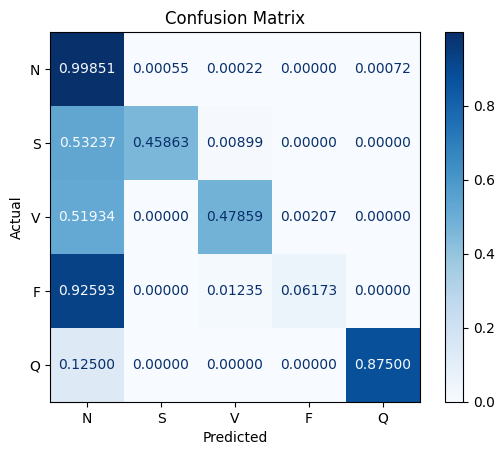

In [78]:
actual_labels = y_test.tolist()

class_labels = ["N", "S", "V", "F", "Q"]

cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3,4])

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format=".5f")

plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [79]:
report = classification_report(all_labels, all_preds, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           N       0.93      1.00      0.96     18117
           S       0.96      0.46      0.62       556
           V       0.98      0.48      0.64      1448
           F       0.77      0.06      0.11       162
           Q       0.99      0.88      0.93      1608

    accuracy                           0.93     21891
   macro avg       0.93      0.57      0.65     21891
weighted avg       0.94      0.93      0.92     21891

